In [1]:
%pylab inline
import pandas as pd

rcParams['axes.spines.right'] = False
rcParams['axes.spines.top'] = False

def xpercent_scale():
    gca().set_xticklabels(['{:.0f}%'.format(x*100) for x in gca().get_xticks()])

Populating the interactive namespace from numpy and matplotlib


In [46]:
results = pd.read_csv('MOB_final_results.csv', index_col=0).query('g != "log_total_count"')

results['pval'] = results['pval'].clip_lower(results.query('pval > 0')['pval'].min() / 2)
results['qval'] = results['qval'].clip_lower(results.query('qval > 0')['qval'].min() / 2)

sample_info = pd.read_csv('MOB_sample_info.csv', index_col=0)

df = pd.read_csv('data/Rep11_MOB_0.csv', index_col=0)
df = df.T[df.sum(0) >= 3].T  # Filter practically unobserved genes
sample_info = sample_info.query('total_counts > 10')  # Remove empty features
df = df.loc[sample_info.index]

In [48]:
import NaiveDE

In [49]:
dfm = NaiveDE.stabilize(df.T).T
res = NaiveDE.regress_out(sample_info, dfm.T, 'np.log(total_counts)').T

In [50]:
idx = res.var().sort_values(ascending=False).head(1000).index

In [51]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale

In [52]:
pca = PCA()
Y = pca.fit_transform(scale(res[idx], 1))

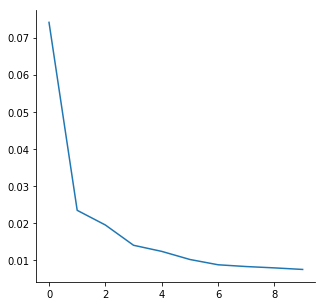

In [53]:
plt.plot(pca.explained_variance_ratio_[:10]);

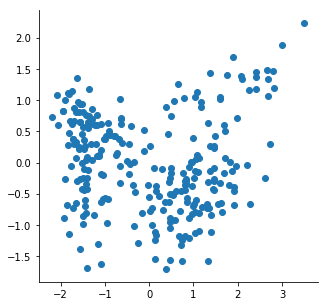

In [54]:
figsize(5, 5)
plt.scatter(Y[:, 0], Y[:, 1]);

In [55]:
from sklearn.mixture import BayesianGaussianMixture

In [56]:
gmm = BayesianGaussianMixture(n_components=20, max_iter=10000)

In [57]:
gmm.fit(Y[:, :2])

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
            degrees_of_freedom_prior=None, init_params='kmeans',
            max_iter=10000, mean_precision_prior=None, mean_prior=None,
            n_components=20, n_init=1, random_state=None, reg_covar=1e-06,
            tol=0.001, verbose=0, verbose_interval=10, warm_start=False,
            weight_concentration_prior=None,
            weight_concentration_prior_type='dirichlet_process')

In [58]:
phi_hat = gmm.predict(Y[:, :2])

In [59]:
sample_info['PC1'] = Y[:, 0]
sample_info['PC2'] = Y[:, 1]
sample_info['cluster'] = phi_hat

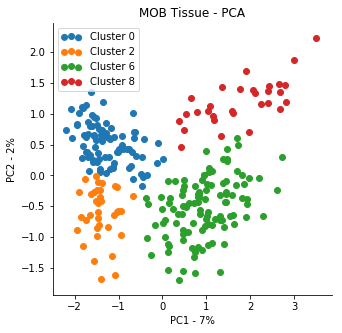

In [60]:
figsize(5, 5)
for i, g in sample_info.groupby('cluster'):
    plt.scatter(g.PC1, g.PC2, label=f'Cluster {i}')
    
plt.xlabel('PC1 - {:.0%}'.format(pca.explained_variance_ratio_[0]))
plt.ylabel('PC2 - {:.0%}'.format(pca.explained_variance_ratio_[1]))

plt.legend(scatterpoints=3);
plt.title('MOB Tissue - PCA');
plt.savefig('PCA_MOB.pdf');

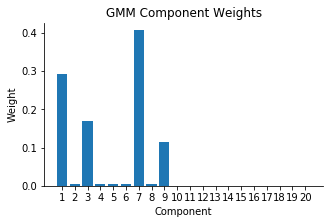

In [81]:
figsize(5, 3)
plt.bar(range(len(gmm.weights_)), gmm.weights_);
plt.title('GMM Component Weights');
plt.xticks(range(0, 20), range(1, 20 + 1));
plt.xlabel('Component')
plt.ylabel('Weight');
plt.savefig('mob-gmm-weights.pdf')

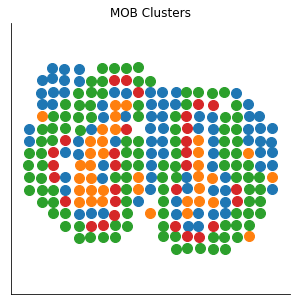

In [80]:
figsize(5, 5)
for i, g in sample_info.groupby('cluster'):
    plt.scatter(g.x, -g.y, label=f'Cluster {i}', s=100)
    
plt.xticks([])
plt.yticks([]);
plt.axis('equal');
plt.title('MOB Clusters');
plt.savefig('MOB_clusters.pdf');

In [63]:
sample_info['cluster'] = phi_hat

In [64]:
de_results = NaiveDE.lr_tests(sample_info, res.T, '~ C(cluster)')

In [65]:
de_results.query('qval < 0.05').shape

(798, 6)

In [67]:
de_results['qval'].shape

(14859,)

In [68]:
results['qval'].shape

(14859,)

In [71]:
de_results = de_results.sort_index()
results = results.sort_values('g')

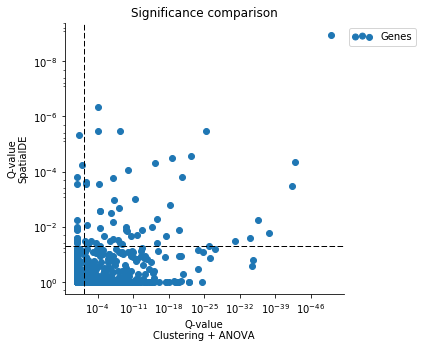

In [79]:
figsize(5, 5)

plt.loglog()
plt.scatter(de_results['qval'].values, results['qval'].values, rasterized=True, label='Genes');

ax = plt.gca()
ax.invert_yaxis()
ax.invert_xaxis();
plt.xlabel('Q-value\nClustering + ANOVA')
plt.ylabel('Q-value\nSpatialDE');

plt.axhline(0.05, color='k', ls='--', lw=1)
plt.axvline(0.05, color='k', ls='--', lw=1);

plt.legend(scatterpoints=3, bbox_to_anchor=[1, 1])

plt.title('Significance comparison')
plt.savefig('MOB_significance_comparison.pdf', bbox_inches='tight')

In [74]:
results.query('qval < 0.05').shape

(67, 18)

In [76]:
sig_genes = results.query('qval < 0.05')['g'].sort_values().values
more_sig = de_results.loc[sig_genes].query('qval > 0.05').sort_values('qval')

In [77]:
more_sig.shape

(15, 6)

In [78]:
67 - 15

52

In [84]:
sample_info.to_csv('MOB_clustering.csv')